In [27]:
import torch
import torch.nn as nn
import torch
import torch.nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.model_selection import train_test_split

In [ ]:
# Define the Variational Autoencoder (VAE) Model


class VAE(torch.nn.Module):
    def __init__(self, latent_dim=512, alpha = 0.00):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3,stride =2, padding=1),
            torch.nn.LeakyReLU(alpha),
            torch.nn.Conv2d(32, 64, kernel_size=3,stride =2, padding=1),
            torch.nn.LeakyReLU(alpha),
            torch.nn.Conv2d(64, 128, kernel_size=3,stride =2, padding=1),
            torch.nn.LeakyReLU(alpha),
            torch.nn.Conv2d(128, 256, kernel_size=3,stride =2,  padding=1),
            torch.nn.LeakyReLU(alpha),
            torch.nn.Flatten()
        )
        self.fc_mu = torch.nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_var = torch.nn.Linear(256 * 2 * 2, latent_dim)

        self.decoder_input = torch.nn.Linear(latent_dim, 256 * 2 * 2)
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = self.fc_mu(x), self.fc_var(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(self.decoder_input(z).view(-1, 256, 2, 2))
        return x_recon, mu, log_var

 10%|█         | 1/10 [00:28<04:14, 28.29s/it]

Epoch [1/10], Loss: 66.7094


 20%|██        | 2/10 [00:51<03:22, 25.31s/it]

Epoch [2/10], Loss: 36.9579


 30%|███       | 3/10 [01:14<02:50, 24.37s/it]

Epoch [3/10], Loss: 29.7872


 40%|████      | 4/10 [01:40<02:29, 24.97s/it]

Epoch [4/10], Loss: 25.2483


 50%|█████     | 5/10 [02:13<02:19, 27.94s/it]

Epoch [5/10], Loss: 21.2716


 60%|██████    | 6/10 [02:37<01:45, 26.41s/it]

Epoch [6/10], Loss: 19.0682


 70%|███████   | 7/10 [03:00<01:16, 25.44s/it]

Epoch [7/10], Loss: 17.3941


 80%|████████  | 8/10 [03:24<00:49, 24.81s/it]

Epoch [8/10], Loss: 16.1078


 90%|█████████ | 9/10 [03:48<00:24, 24.55s/it]

Epoch [9/10], Loss: 14.9562


100%|██████████| 10/10 [04:11<00:00, 25.19s/it]

Epoch [10/10], Loss: 13.8506


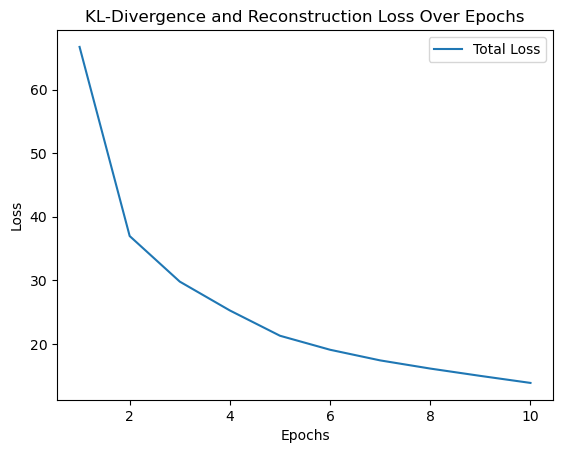

In [ ]:


# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


    
# Define Loss Function
alpha = 0.08

def loss_function(x_recon, x, mu, log_var, alpha= alpha):
    # Reconstruction Loss (MSE or BCE)
    recons_loss = F.mse_loss(x_recon, x, reduction='sum')

    # KL Divergence Loss
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return recons_loss + alpha * kl_loss


def train_vae(model, train_loader, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    train_losses = []
    
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, mu, log_var = model(x)
            loss = loss_function(x_recon, x, mu, log_var)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_loss = train_loss/ len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    plt.plot(range(1, epochs + 1), train_losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('KL-Divergence and Reconstruction Loss Over Epochs')
    plt.legend()
    plt.show()
    
# Instantiate and Train Model
vae = VAE().to(device)
train_vae(vae, train_loader, epochs=10, lr= 1e-4)

# Save Model for Future Use
torch.save(vae.state_dict(), "vae_cifar10.pth")


Text(0.5, 1.0, 'Reconstructed Images')

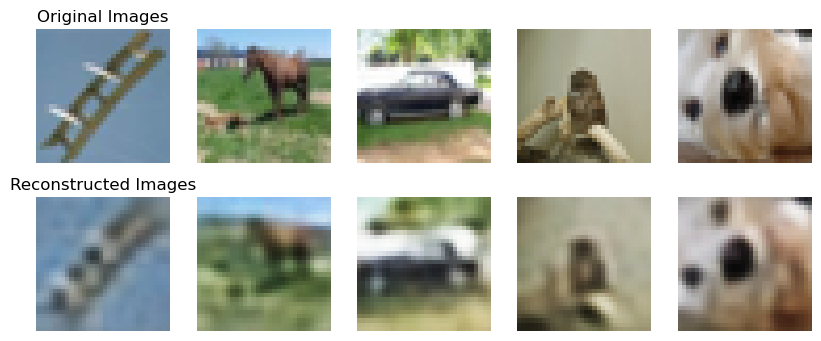

In [29]:
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)

# Load Trained Model
vae = VAE().to(device)  # Ensure VAE class is defined
vae.load_state_dict(torch.load("vae_cifar10.pth", map_location=device))
vae.eval()

# Get 5 test images
data_iter = iter(test_loader)
x_test, _ = next(data_iter)  # Get batch of images
x_test = x_test.to(device)

# Get reconstructed images
with torch.no_grad():
    x_recon, _, _ = vae(x_test)

# Move tensors to CPU for plotting
x_test = x_test.cpu()
x_recon = x_recon.cpu()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(5):
    axes[0, i].imshow(x_test[i].permute(1, 2, 0))  # Original Image
    axes[0, i].axis('off')

    axes[1, i].imshow(x_recon[i].permute(1, 2, 0).numpy())  # Reconstructed Image
    axes[1, i].axis('off')

axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")

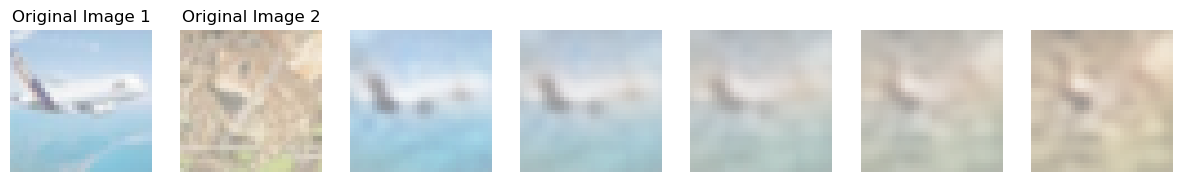

In [30]:
def interpolate_latent_space(model, img1, img2, num_steps=5):
    model.eval()
    
    # Encode both images to get latent representations
    with torch.no_grad():
        x1_enc = model.encoder(img1)
        x2_enc = model.encoder(img2)

        z1 = model.reparameterize(model.fc_mu(x1_enc), model.fc_var(x1_enc))
        z2 = model.reparameterize(model.fc_mu(x2_enc), model.fc_var(x2_enc))

    interpolated_images = []

    for alpha in np.linspace(0, 1, num_steps):
        z_interp = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        
        # Ensure z_interp has shape (batch_size, latent_dim)
        z_interp = z_interp.view(1, 512)  # Shape: (1, latent_dim)

        # Decode the interpolated latent vector
        x_recon = model.decoder(model.decoder_input(z_interp).view(-1, 256, 2, 2))
        interpolated_images.append(x_recon.cpu().squeeze())

    return interpolated_images

import random

# Select two random images from the train dataset
idx1, idx2 = random.sample(range(len(train_dataset)), 2)
img1, _ = train_dataset[idx1]
img2, _ = train_dataset[idx2]

# Convert to batch format
img1, img2 = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device)

# Perform interpolation
interpolated_images = interpolate_latent_space(vae, img1, img2)

# Plot the interpolated images
fig, axes = plt.subplots(1, len(interpolated_images) + 2, figsize=(15, 3))

# Plot original images with labels
original_images = [img1, img2]
titles = ["Original Image 1", "Original Image 2"]

for i, (img, title) in enumerate(zip(original_images, titles)):
    img = img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    axes[i].imshow(img * 0.5 + 0.5)  # Unnormalize
    axes[i].set_title(title)
    axes[i].axis("off")

# Plot interpolated images
for i, img in enumerate(interpolated_images):
    img = img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    axes[i + 2].imshow(img * 0.5 + 0.5)  # Unnormalize
    axes[i + 2].axis("off")

plt.show()



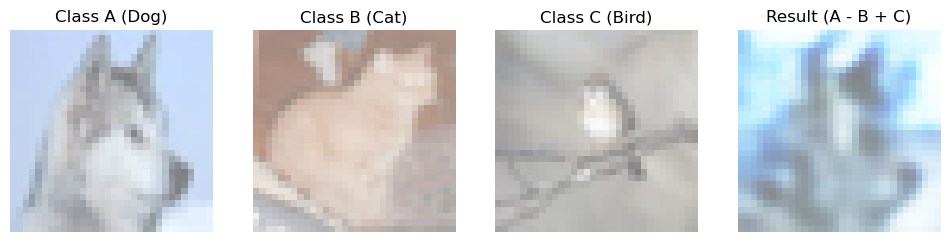

In [31]:
import random

def get_image_by_class(dataset, target_class, max_attempts=1000):
    """Fetches a random image from the dataset belonging to a given class."""
    attempts = 0
    while attempts < max_attempts:
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        if label == target_class:
            return img.unsqueeze(0).to(device)
        attempts += 1
    raise ValueError(f"Could not find an image of class {target_class}")

def latent_space_arithmetic(model, class_a, class_b, class_c):
    """
    Performs latent space arithmetic: 
    `vector_A - vector_B + vector_C` in latent space.
    
    Args:
    - model: Trained VAE model
    - class_a: Index of class A (e.g., Dog)
    - class_b: Index of class B (e.g., Cat)
    - class_c: Index of class C (e.g., Bird)

    Returns:
    - Decoded image from the modified latent vector.
    """
    model.eval()  # Set model to evaluation mode

    # Fetch images from dataset
    img_a = get_image_by_class(train_dataset, class_a)
    img_b = get_image_by_class(train_dataset, class_b)
    img_c = get_image_by_class(train_dataset, class_c)

    # Encode images to latent space
    with torch.no_grad():
        z_a = model.reparameterize(model.fc_mu(model.encoder(img_a)), 
                                   model.fc_var(model.encoder(img_a)))
        z_b = model.reparameterize(model.fc_mu(model.encoder(img_b)), 
                                   model.fc_var(model.encoder(img_b)))
        z_c = model.reparameterize(model.fc_mu(model.encoder(img_c)), 
                                   model.fc_var(model.encoder(img_c)))

    # Perform arithmetic: A - B + C
    z_result = z_a - z_b + z_c

    # Decode the new latent vector
    with torch.no_grad():
        generated_img = model.decoder(model.decoder_input(z_result).view(-1, 256, 2, 2))

    return img_a, img_b, img_c, generated_img

# Call the function with CIFAR-10 labels (e.g., Dog=5, Cat=3, Bird=2)
img_a, img_b, img_c, result_img = latent_space_arithmetic(vae, class_a=5, class_b=3, class_c=2)

# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ["Class A (Dog)", "Class B (Cat)", "Class C (Bird)", "Result (A - B + C)"]

for i, (img, title) in enumerate(zip([img_a, img_b, img_c, result_img], titles)):
    img = img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    axes[i].imshow(img * 0.5 + 0.5)  # Unnormalize
    axes[i].set_title(title)
    axes[i].axis("off")

plt.show()


=== Average Evaluation Metrics ===
SSIM: 0.6533
PSNR: 23.8636
MAE: 0.0494
MSE: 0.0046


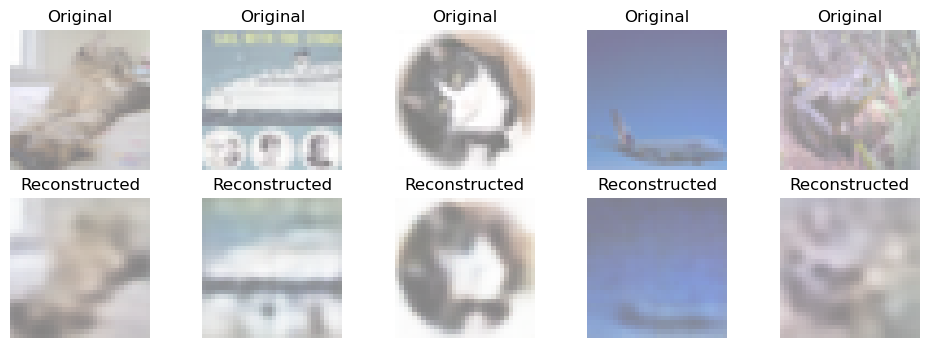

In [32]:


# Define Error Metrics
def compute_metrics(original, reconstructed):
    """
    Computes SSIM, PSNR, MAE, and MSE between original and reconstructed images.

    Args:
    - original: Original image tensor (C, H, W)
    - reconstructed: Reconstructed image tensor (C, H, W)

    Returns:
    - Dictionary of computed metric values.
    """
    original = original.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
    reconstructed = reconstructed.cpu().numpy().transpose(1, 2, 0)

    # Compute metrics
    ssim_val = ssim(original, reconstructed, channel_axis=-1, data_range=1.0, win_size=3)
    psnr_val = psnr(original, reconstructed, data_range=1.0)
    mae_val = np.mean(np.abs(original - reconstructed))
    mse_val = np.mean((original - reconstructed) ** 2)

    return {"SSIM": ssim_val, "PSNR": psnr_val, "MAE": mae_val, "MSE": mse_val}


# Inference on Unseen Test Images
def infer_and_evaluate(model, test_loader, num_images=5):
    """
    Infers the trained VAE on test images and evaluates reconstruction quality.

    Args:
    - model: Trained VAE model
    - test_loader: DataLoader for test dataset
    - num_images: Number of images to visualize and evaluate

    Returns:
    - Prints evaluation metrics and shows images.
    """
    model.eval()  # Set model to evaluation mode

    original_images = []
    reconstructed_images = []
    metrics = []

    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            if i >= num_images:
                break  # Limit to num_images
            
            x = x.to(device)
            x_recon, _, _ = model(x)

            # Store original and reconstructed images
            original_images.append(x[0])
            reconstructed_images.append(x_recon[0])

            # Compute quality metrics
            metrics.append(compute_metrics(x[0], x_recon[0]))

    # Print average metrics
    avg_metrics = {key: np.mean([m[key] for m in metrics]) for key in metrics[0]}
    print("=== Average Evaluation Metrics ===")
    for key, value in avg_metrics.items():
        print(f"{key}: {value:.4f}")

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        axes[0, i].imshow(original_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        axes[1, i].imshow(reconstructed_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].axis("off")
        axes[1, i].set_title("Reconstructed")

    plt.show()

# Call inference function
infer_and_evaluate(vae, test_loader, num_images=5)
